# Wiki-large cleaned

In [1]:
from datasets import load_from_disk

wiki_dataset = load_from_disk("../data/wiki-large_clean")

In [2]:
wiki_dataset

DatasetDict({
    train: Dataset({
        features: ['Normal', 'Simple'],
        num_rows: 110287
    })
    validation: Dataset({
        features: ['Normal', 'Simple'],
        num_rows: 415
    })
    test: Dataset({
        features: ['Normal', 'Simple'],
        num_rows: 189
    })
})

# Text length

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

def get_text_lengths(dataset, column_name):
    return [len(text.split()) for text in dataset[column_name]]

# get text lengths for each split
train_normal_lengths = get_text_lengths(wiki_dataset['train'], 'Normal')
train_simple_lengths = get_text_lengths(wiki_dataset['train'], 'Simple')

val_normal_lengths = get_text_lengths(wiki_dataset['validation'], 'Normal')
val_simple_lengths = get_text_lengths(wiki_dataset['validation'], 'Simple')

test_normal_lengths = get_text_lengths(wiki_dataset['test'], 'Normal')
test_simple_lengths = get_text_lengths(wiki_dataset['test'], 'Simple')

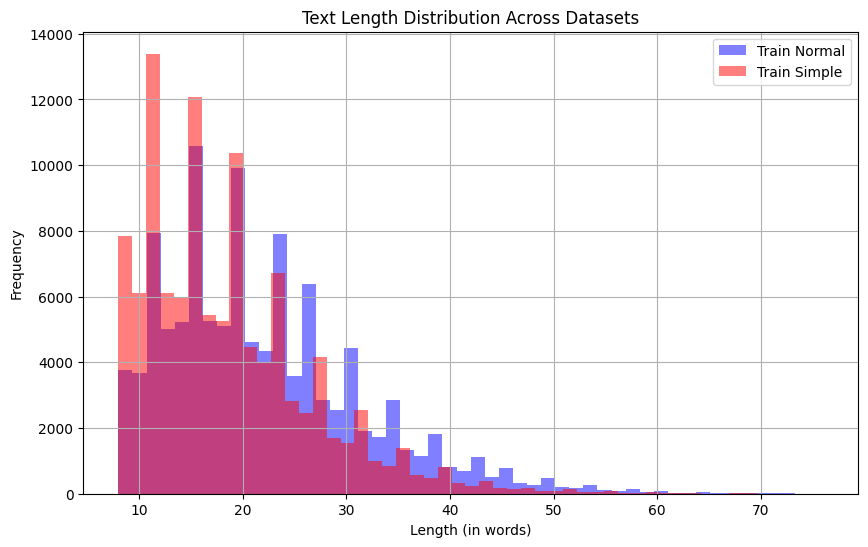

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(train_normal_lengths, bins=50, alpha=0.5, label='Train Normal', color='blue')
plt.hist(train_simple_lengths, bins=50, alpha=0.5, label='Train Simple', color='red')

plt.title('Text Length Distribution Across Datasets')
plt.xlabel('Length (in words)')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

In [7]:
df_lengths = pd.DataFrame({
    'Train Normal': train_normal_lengths,
    'Train Simple': train_simple_lengths,
})

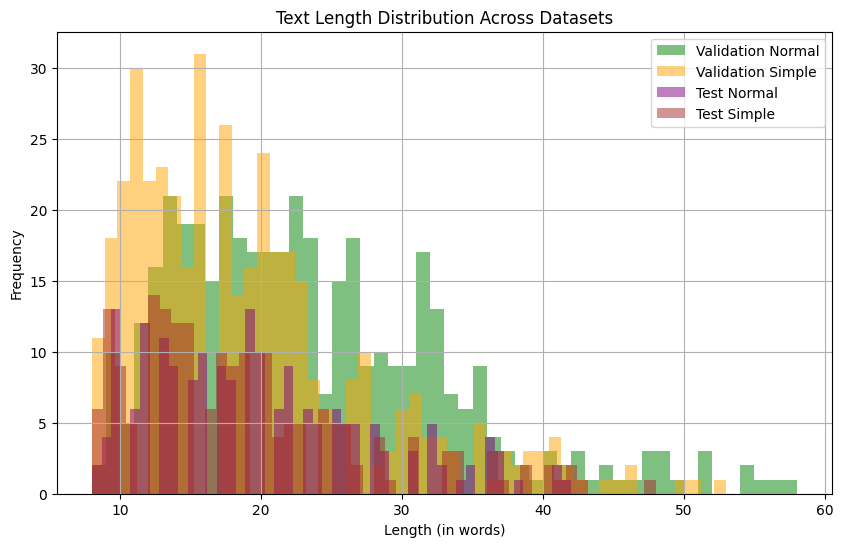

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(val_normal_lengths, bins=50, alpha=0.5, label='Validation Normal', color='green')
plt.hist(val_simple_lengths, bins=50, alpha=0.5, label='Validation Simple', color='orange')
plt.hist(test_normal_lengths, bins=50, alpha=0.5, label='Test Normal', color='purple')
plt.hist(test_simple_lengths, bins=50, alpha=0.5, label='Test Simple', color='brown')

plt.title('Text Length Distribution Across Datasets')
plt.xlabel('Length (in words)')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

# Identify insertion-main texts

https://huggingface.co/Salesforce/bic_simple_edit_id

In [20]:
import difflib

normal_sentence = "The term jargon may have the following meanings."
simplified_sentence = "The jargon may have the following meanings."

diff = difflib.ndiff(normal_sentence.split(), simplified_sentence.split())
print('\n'.join(diff))

  The
- term
  jargon
  may
  have
  the
  following
  meanings.


In [21]:
import difflib

def count_insertions_and_deletions(normal_sentence, simple_sentence):
    """
    count the number of insertions and deletions between two sentences.
    """
    diff = list(difflib.ndiff(normal_sentence.split(), simple_sentence.split()))
    insertions = sum(1 for token in diff if token.startswith('+ '))
    deletions = sum(1 for token in diff if token.startswith('- '))
    
    return insertions, deletions

def mostly_insertions(normal_sentence, simple_sentence, threshold=0.6):
    """
    check if a sentence pair has mostly insertions compared to other changes.
    """
    insertions, deletions = count_insertions_and_deletions(normal_sentence, simple_sentence)
    total_changes = insertions + deletions
    
    # if there are no changes
    if total_changes == 0:
        return False
    
    # proportion of insertions
    insertion_ratio = insertions / total_changes
    return insertion_ratio >= threshold

In [27]:
print("Num of all records: ", len(wiki_dataset['train']))

Num of all records:  110287


In [32]:
from tqdm.notebook import tqdm

mostly_insertion_indices = []
for idx, example in tqdm(enumerate(wiki_dataset['train']), total = len(wiki_dataset['train'])):
    normal_sentence = example['Normal']
    simple_sentence = example['Simple']
    
    if mostly_insertions(normal_sentence, simple_sentence, threshold=0.8):
        mostly_insertion_indices.append(idx)

print(f"Found {len(mostly_insertion_indices)} examples with mostly insertions.")

  0%|          | 0/110287 [00:00<?, ?it/s]

Found 6531 examples with mostly insertions.


In [35]:
for idx in mostly_insertion_indices[-5:]:
    normal_sentence = wiki_dataset['train'][idx]['Normal']
    simple_sentence = wiki_dataset['train'][idx]['Simple']
    
    print(f"Index: {idx}")
    print(f"Normal: {normal_sentence}")
    print(f"Simple: {simple_sentence}", end='\n\n')
    print("-----")

Index: 110159
Normal: the nhl season was the th season of the national hockey league.
Simple: the nhl season was the th season of the national hockey league lrb nhl rrb.

-----
Index: 110204
Normal: on july neymar was selected in the squad for the brazil team by new head coach mano menezes for a friendly match against the usa on august.
Simple: after neymar s performances for brazil s u team at the u world cup on july neymar was selected in the squad for the brazil team by new head coach mano menezes for a friendly match against usa team on august.

-----
Index: 110225
Normal: the flames and the lightning battled hard in the stanley cup finals.
Simple: the flames and the lightning battled hard in the stanley cup finals eventually pushing the series to seven games.

-----
Index: 110231
Normal: tony the tiger was originally voiced by thurl ravenscroft who continued until his death in.
Simple: tony the tiger was originally voiced by thurl ravenscroft who continued providing his voice unti